<a id="1"></a>
# <div style="padding:20px;color:white;margin:0;font-size:25px;font-family:Calibri;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b> ✈️ Predictive model for Flight Price Prediction ✈️ </b></div>

<span style="color:darkblue; font-weight:bold; font-size:24px;">Importing Libraries</span>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from tqdm import tqdm

from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from mlxtend.regressor import StackingCVRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


<span style="color:darkblue; font-weight:bold; font-size:24px;">Loading the Data</span>

In [2]:
df = pd.read_csv('flights.csv')
df.head()

,Searched Date,Departure Date,Arrival Date,Flight Lands Next Day,Departure Airport,Arrival Airport,Number Of Stops,Route,Airline,Cabin,Price
0,2024-06-30,2024-07-16 23:48:00,2024-07-17 15:03:00,1,LAS,BOS,1,ATL,Spirit Airlines,Economy,$83
1,2024-06-30,2024-07-16 09:34:00,2024-07-16 19:43:00,0,LAS,BOS,1,EWR,Spirit Airlines,Economy,$100
2,2024-06-30,2024-07-16 23:48:00,2024-07-17 15:03:00,1,LAS,BOS,1,ATL,Spirit Airlines,Economy,$78
3,2024-06-30,2024-07-16 08:30:00,2024-07-16 19:37:00,0,LAS,BOS,1,IAH,Spirit Airlines,Economy,$100
4,2024-06-30,2024-07-16 07:00:00,2024-07-16 16:36:00,0,LAS,BOS,1,ORD,American Airlines,Basic Economy,$148


<span style="color:darkblue; font-weight:bold; font-size:24px;">Data Exploration</span>

In [3]:
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns")

There are 317260 rows and 11 columns


In [4]:
list(df.columns)

['Searched Date',
 'Departure Date',
 'Arrival Date',
 'Flight Lands Next Day',
 'Departure Airport',
 'Arrival Airport',
 'Number Of Stops',
 'Route',
 'Airline',
 'Cabin',
 'Price']

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">
    
<span style="color:darkblue; font-weight:bold; font-size:24px;">Columns Description for Flight Price Prediction Dataset</span>


1. **Searched Date**  
   - The date when the flight information was searched.  
   - Example: "2024-01-15".

2. **Departure Date**  
   - The date when the flight is scheduled to depart.  
   - Example: "2024-01-20".

3. **Arrival Date**  
   - The date when the flight is scheduled to arrive at the destination.  
   - Example: "2024-01-21".  

4. **Flight Lands Next Day**  
   - Indicates whether the flight lands on the next day.  
   - Possible values: `Yes` or `No`.  
   - Useful for understanding overnight flights or long durations.

5. **Departure Airport**  
   - The airport from which the flight departs.    

6. **Arrival Airport**  
   - The destination airport where the flight lands.    

7. **Number of Stops**  
   - The number of layovers or stops during the flight.  
   - Possible values: `0` (Non-stop), `1`, `2`, etc.  
   - Directly impacts travel time and flight price.

8. **Route**  
   - The sequence of airports in the flight journey.    

9. **Airline**  
   - The airline operating the flight.  

10. **Cabin**  
    - The travel class or cabin type for the flight.  
    - Possible values: `Economy`, `Business`, `First Class`.  
    - Affects the comfort level and ticket price.

11. **Price**  
    - The final ticket price for the flight.   
    - This is the target variable for the prediction model.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317260 entries, 0 to 317259
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Searched Date          317260 non-null  object
 1   Departure Date         317260 non-null  object
 2   Arrival Date           317260 non-null  object
 3   Flight Lands Next Day  317260 non-null  int64 
 4   Departure Airport      317260 non-null  object
 5   Arrival Airport        317260 non-null  object
 6   Number Of Stops        317260 non-null  int64 
 7   Route                  278863 non-null  object
 8   Airline                317260 non-null  object
 9   Cabin                  317260 non-null  object
 10  Price                  317260 non-null  object
dtypes: int64(2), object(9)
memory usage: 26.6+ MB


<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<span style="color:darkblue; font-weight:bold; font-size:24px;">Insights:</span>

- ##### Out of **11 columns**, **9 are categorical** and **2 are numerical**
- ##### Route column has missing values, while other columns have no missing values

<span style="color:darkblue; font-weight:bold; font-size:24px;">Converting field into correct data types</span>


In [6]:
## Converting Searched Date, Departure Date, Arrival Date into datetime formats

df['Searched Date'] = pd.to_datetime(df['Searched Date'])
df['Departure Date'] = pd.to_datetime(df['Departure Date'])
df['Arrival Date'] = pd.to_datetime(df['Arrival Date'])

##converting price column into numerical
df['Price'] = df['Price'].str.replace('$', '').str.replace(',', '').astype(int)

In [7]:
df.dtypes

Searched Date            datetime64[ns]
Departure Date           datetime64[ns]
Arrival Date             datetime64[ns]
Flight Lands Next Day             int64
Departure Airport                object
Arrival Airport                  object
Number Of Stops                   int64
Route                            object
Airline                          object
Cabin                            object
Price                             int64
dtype: object

In [8]:
## Diff between Searched Date and Departure Date inorder to get the no of days before travel

df['DaysbeforeTravel'] = (df['Departure Date'] - df['Searched Date']).dt.days
df.head()

,Searched Date,Departure Date,Arrival Date,Flight Lands Next Day,Departure Airport,Arrival Airport,Number Of Stops,Route,Airline,Cabin,Price,DaysbeforeTravel
0,2024-06-30,2024-07-16 23:48:00,2024-07-17 15:03:00,1,LAS,BOS,1,ATL,Spirit Airlines,Economy,83,16
1,2024-06-30,2024-07-16 09:34:00,2024-07-16 19:43:00,0,LAS,BOS,1,EWR,Spirit Airlines,Economy,100,16
2,2024-06-30,2024-07-16 23:48:00,2024-07-17 15:03:00,1,LAS,BOS,1,ATL,Spirit Airlines,Economy,78,16
3,2024-06-30,2024-07-16 08:30:00,2024-07-16 19:37:00,0,LAS,BOS,1,IAH,Spirit Airlines,Economy,100,16
4,2024-06-30,2024-07-16 07:00:00,2024-07-16 16:36:00,0,LAS,BOS,1,ORD,American Airlines,Basic Economy,148,16


In [9]:
## Travel time in hours
df['TravelTime'] = (df['Arrival Date'] - df['Departure Date']).dt.total_seconds()/3600
df.head()

,Searched Date,Departure Date,Arrival Date,Flight Lands Next Day,Departure Airport,Arrival Airport,Number Of Stops,Route,Airline,Cabin,Price,DaysbeforeTravel,TravelTime
0,2024-06-30,2024-07-16 23:48:00,2024-07-17 15:03:00,1,LAS,BOS,1,ATL,Spirit Airlines,Economy,83,16,15.250000
1,2024-06-30,2024-07-16 09:34:00,2024-07-16 19:43:00,0,LAS,BOS,1,EWR,Spirit Airlines,Economy,100,16,10.150000
2,2024-06-30,2024-07-16 23:48:00,2024-07-17 15:03:00,1,LAS,BOS,1,ATL,Spirit Airlines,Economy,78,16,15.250000
3,2024-06-30,2024-07-16 08:30:00,2024-07-16 19:37:00,0,LAS,BOS,1,IAH,Spirit Airlines,Economy,100,16,11.116667
4,2024-06-30,2024-07-16 07:00:00,2024-07-16 16:36:00,0,LAS,BOS,1,ORD,American Airlines,Basic Economy,148,16,9.600000


<span style="color:darkblue; font-weight:bold; font-size:24px;">Dropping Unnecessary columns</span>

In [10]:
df = df.drop(columns = ['Searched Date', 'Departure Date', 'Arrival Date'], axis = 1)
df.head()

,Flight Lands Next Day,Departure Airport,Arrival Airport,Number Of Stops,Route,Airline,Cabin,Price,DaysbeforeTravel,TravelTime
0,1,LAS,BOS,1,ATL,Spirit Airlines,Economy,83,16,15.250000
1,0,LAS,BOS,1,EWR,Spirit Airlines,Economy,100,16,10.150000
2,1,LAS,BOS,1,ATL,Spirit Airlines,Economy,78,16,15.250000
3,0,LAS,BOS,1,IAH,Spirit Airlines,Economy,100,16,11.116667
4,0,LAS,BOS,1,ORD,American Airlines,Basic Economy,148,16,9.600000


<span style="color:darkblue; font-weight:bold; font-size:24px;">Statistical Details</span>

In [11]:
df.describe()

,Flight Lands Next Day,Number Of Stops,Price,DaysbeforeTravel,TravelTime
count,317260.000000,317260.000000,317260.000000,317260.000000,317260.000000
mean,0.230246,1.070144,359.891647,33.981066,9.427938
std,0.420991,0.559399,214.971750,45.069549,4.426376
min,0.000000,0.000000,15.000000,6.000000,1.100000
25%,0.000000,1.000000,217.000000,12.000000,6.066667
50%,0.000000,1.000000,316.000000,15.000000,9.016667
75%,0.000000,1.000000,457.000000,22.000000,12.316667
max,1.000000,3.000000,3688.000000,167.000000,33.600000


<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<span style="color:brown; font-weight:bold; font-size:24px;">Insights:</span>

- ##### Aproximately, **23%** of the **flights land the next day** with significance variation in the occurence of the next day landing 
- ##### The avg flight has **just over 1 stop** with most flights either being **non-stop or having 1 stop**, and a **few having up to 3 stops**.
- ##### Flight prices vary widely, with an **average price of 359.89** but a **high standard deviation (214.97)**, indicating a significant range of prices from **15 to 3688**. The distribution is **skewed** with a long tail **towrads higher prices**.
- ##### Fligts are typically booked about **34 days in advance**, but booking times range between [6, 167] days which indicates high variability
- ##### The average **flight travel time** is **9.4 hours**, but there is considerable variation, with some flights taking as little as **1.1 hours** and others lasting up to **33.6 hours**

<span style="color:brown; font-weight:bold; font-size:24px;">Checking for Null Values</span>

In [12]:
df.isnull().sum()

Flight Lands Next Day        0
Departure Airport            0
Arrival Airport              0
Number Of Stops              0
Route                    38397
Airline                      0
Cabin                        0
Price                        0
DaysbeforeTravel             0
TravelTime                   0
dtype: int64

In [13]:
missing_count = round(df['Route'].isnull().sum()/(len(df)) * 100,2)
print(f"Missing values in Route: {missing_count}%")


Missing values in Route: 12.1%


In [14]:
# Distribution of missing Route across other features

missing_route = df[df['Route'].isnull()]
missing_route.head()

,Flight Lands Next Day,Departure Airport,Arrival Airport,Number Of Stops,Route,Airline,Cabin,Price,DaysbeforeTravel,TravelTime
15,0,LAS,BOS,0,NaN,Delta,Basic Economy,229,16,8.466667
16,1,LAS,BOS,0,NaN,JetBlue,Blue Basic,184,16,8.116667
17,0,LAX,ORD,0,NaN,Spirit Airlines,Economy,68,14,6.216667
18,0,LAX,ORD,0,NaN,Spirit Airlines,Economy,66,14,6.216667
19,1,LAX,ORD,0,NaN,Spirit Airlines,Economy,66,14,6.200000


In [15]:
missing_route['Number Of Stops'].value_counts()

Number Of Stops
0    38397
Name: count, dtype: int64

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<span style="color:brown; font-weight:bold; font-size:24px;">Insights:</span>

- ##### After analysing all the missing values in the Column Route, im filling it with **Direct**

In [16]:
df['Route'] = df['Route'].fillna('Direct')

In [17]:
df.isnull().sum().sum()

0

<span style="color:brown; font-weight:bold; font-size:24px;">Visualizing Target Variable (Flight Prices)</span>


In [18]:
df['Price'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
Price,317260.0,359.891647,214.97175,15.0,217.0,316.0,457.0,3688.0


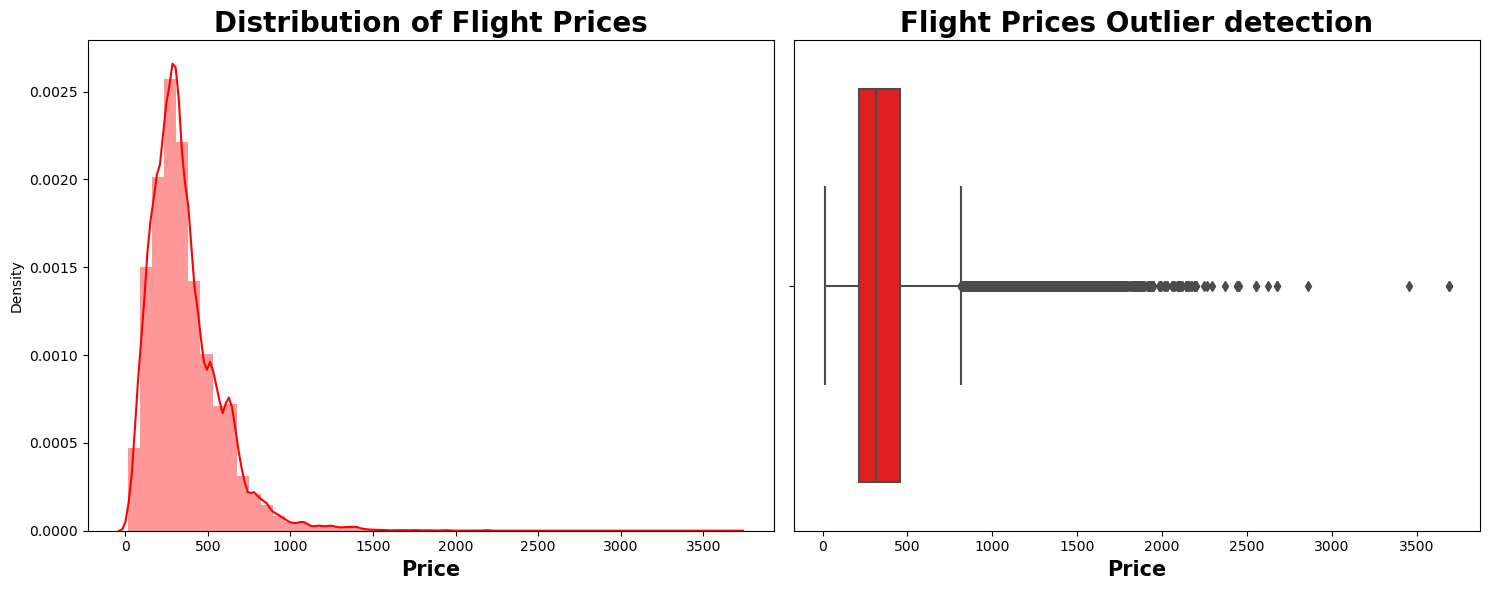

In [19]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.distplot(df['Price'], color = 'Red', kde = True)
plt.title("Distribution of Flight Prices", fontweight = 'bold', size = 20)
plt.xlabel("Price", fontweight = 'bold', size = 15)

plt.subplot(1,2,2)
sns.boxplot(x = df['Price'], color = "Red")
plt.title("Flight Prices Outlier detection", fontweight = 'bold', size = 20)
plt.xlabel("Price", fontweight = 'bold', size = 15)
plt.tight_layout()

plt.show()

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<span style="color:brown; font-weight:bold; font-size:24px;">Insights:</span>

- ##### Majority of the prices are between around **200 and 600**. Boxplot shows that Outliers are present above 1000 approximately indicating a **highly Right Skewed distribution**
- ##### To achieve the Normal distribution, we can perform different techniques like **Johnsonsu Transformation, Norm Transformation , Log Normal Transformation**

In [20]:
high_prices = df[df['Price'] > 1000]
print(f"Number of flights with prices greater than 1000: {len(high_prices)}")


Number of flights with prices greater than 1000: 4687


<span style="color:brown; font-weight:bold; font-size:24px;">Transformation techniques on Price feature</span>

Text(0.5, 1.0, 'Normal Transformation')

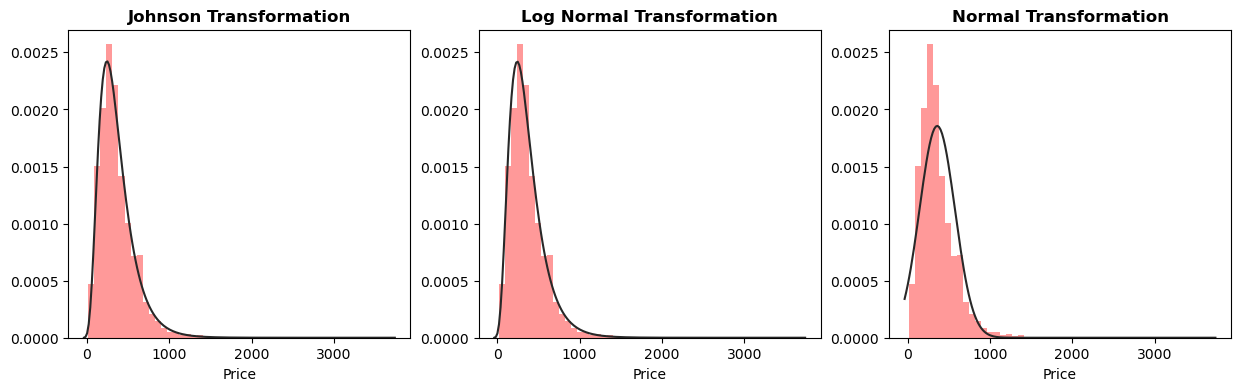

In [21]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
sns.distplot(df['Price'], color = 'red', kde = False, fit=stats.johnsonsu)
plt.title("Johnson Transformation", fontweight = 'black')

plt.subplot(1,3,2)
sns.distplot(df['Price'], color = 'red', kde = False, fit=stats.lognorm)
plt.title("Log Normal Transformation", fontweight = 'black')

plt.subplot(1,3,3)
sns.distplot(df['Price'], color = 'red', kde = False, fit=stats.norm)
plt.title("Normal Transformation", fontweight = 'black')


<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<span style="color:brown; font-weight:bold; font-size:24px;">Insights:</span>

- ##### Even after applying Transformation techniques, it still didnt achieve the Normal distribution. Hence, going with the outlier treatment

<span style="color:brown; font-weight:bold; font-size:24px;">Outlier Treatment</span>

In [22]:
## Removing outlier i.e. prices over 1000

## Calculate Q1, Q3 and IQR
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)

IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataset to remove outliers
df_no_outliers = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]

# Print the shape of the cleaned dataframe
print(f"Shape of Original DataFrame: {df.shape}")
print(f"Shape of DataFrame after removing Outliers: {df_no_outliers.shape}")

Shape of Original DataFrame: (317260, 10)
Shape of DataFrame after removing Outliers: (306282, 10)


In [23]:
df['Price'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
Price,317260.0,359.891647,214.97175,15.0,217.0,316.0,457.0,3688.0


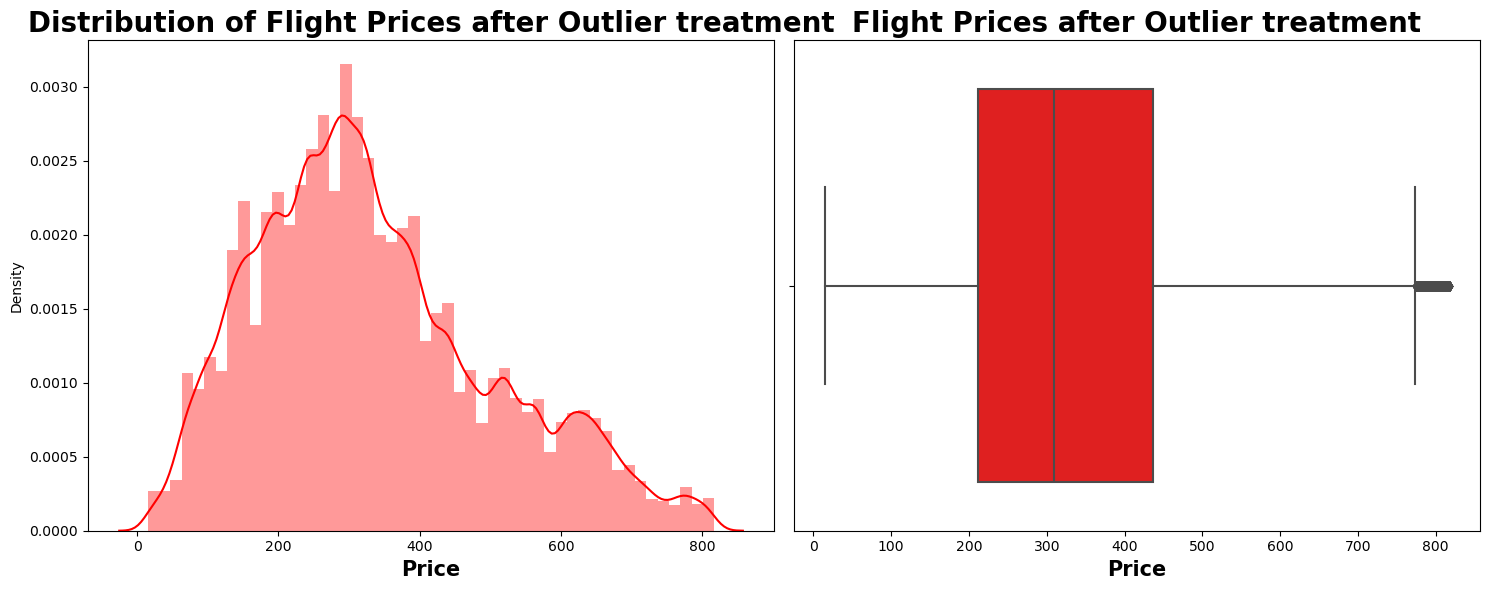

In [24]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.distplot(df_no_outliers['Price'], color = 'Red', kde = True)
plt.title("Distribution of Flight Prices after Outlier treatment", fontweight = 'bold', size = 20)
plt.xlabel("Price", fontweight = 'bold', size = 15)

plt.subplot(1,2,2)
sns.boxplot(x = df_no_outliers['Price'], color = "Red")
plt.title("Flight Prices after Outlier treatment", fontweight = 'bold', size = 20)
plt.xlabel("Price", fontweight = 'bold', size = 15)
plt.tight_layout()

plt.show()

In [25]:
## making a copy 

df1 = df.copy()

<span style="color:brown; font-weight:bold; font-size:24px;">Modifying the Dataframe to keep top 10 airlines</span>

In [26]:
top_10_airlines = df1['Airline'].value_counts().head(10).index
df1 = df1[df1['Airline'].isin(top_10_airlines)]

In [27]:
df1

,Flight Lands Next Day,Departure Airport,Arrival Airport,Number Of Stops,Route,Airline,Cabin,Price,DaysbeforeTravel,TravelTime
0,1,LAS,BOS,1,ATL,Spirit Airlines,Economy,83,16,15.250000
1,0,LAS,BOS,1,EWR,Spirit Airlines,Economy,100,16,10.150000
2,1,LAS,BOS,1,ATL,Spirit Airlines,Economy,78,16,15.250000
3,0,LAS,BOS,1,IAH,Spirit Airlines,Economy,100,16,11.116667
4,0,LAS,BOS,1,ORD,American Airlines,Basic Economy,148,16,9.600000
...,...,...,...,...,...,...,...,...,...,...
317255,0,LAS,BOS,1,DEN,United Airlines,Basic Economy,219,17,10.716667
317256,0,LAS,BOS,1,PHX,American Airlines,Basic Economy,218,17,10.700000
317257,1,LAS,BOS,1,IAD,United Airlines,Economy,198,17,10.783333
317258,1,LAS,BOS,1,JFK,JetBlue,Blue Basic,154,17,13.466667


<span style="color:brown; font-weight:bold; font-size:24px;">Distribution of Top 10 Airlines</span>

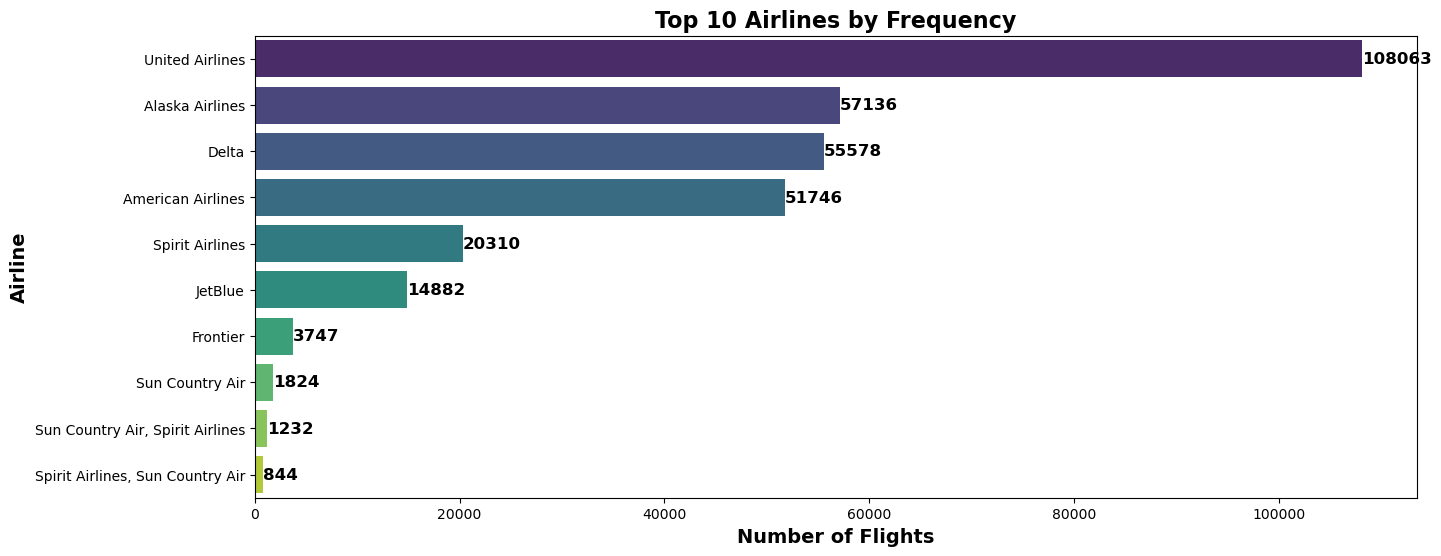

In [28]:
top_10_airlines = df1['Airline'].value_counts().head(10)

plt.figure(figsize=(15,6))
ax=sns.barplot(y = top_10_airlines.index, x= top_10_airlines.values,palette="viridis")

for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=12, label_type='edge', fontweight='bold')
    
plt.title("Top 10 Airlines by Frequency", fontsize=16, fontweight = 'bold')
plt.xlabel("Number of Flights", fontsize=14, fontweight = 'bold')
plt.ylabel("Airline", fontsize=14,fontweight = 'bold')
plt.show()

<span style="color:brown; font-weight:bold; font-size:24px;">Distribution of Cabin Types</span>

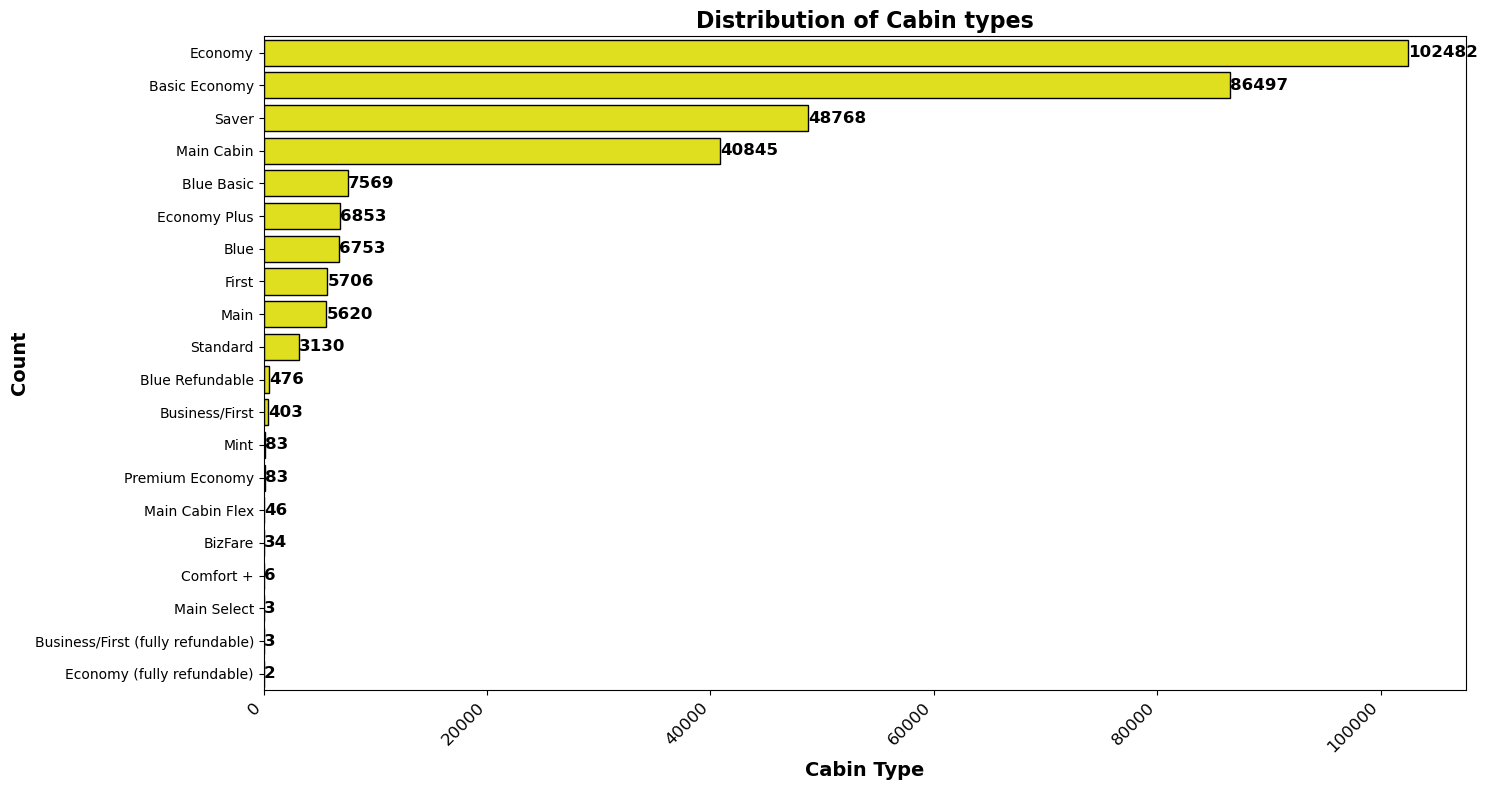

In [29]:
plt.figure(figsize=(15,8))
ax=sns.barplot(y= df1['Cabin'].value_counts().index, x= df1['Cabin'].value_counts().values, color = 'yellow', edgecolor = 'black')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=12, label_type='edge', fontweight='bold')

plt.title("Distribution of Cabin types",fontsize=16, fontweight = 'bold')
plt.xlabel("Cabin Type",fontsize=14, fontweight = 'bold')
plt.ylabel("Count",fontsize=14, fontweight = 'bold')

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()


<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<span style="color:brown; font-weight:bold; font-size:24px;">Insights:</span>

- ##### **Cabin Feature** has **High Cardinality** . So we should do encoding

In [30]:
(df1['Cabin'].unique())

array(['Economy', 'Basic Economy', 'Blue Basic', 'Saver', 'Standard',
       'Main Cabin', 'Blue', 'Main', 'First', 'Mint', 'Economy Plus',
       'Blue Refundable', 'BizFare', 'Business/First', 'Main Cabin Flex',
       'Premium Economy', 'Main Select', 'Comfort +',
       'Business/First (fully refundable)', 'Economy (fully refundable)'],
      dtype=object)

In [31]:
## creating the maping dictionary --> Economy, Business, First

cabin_mapping = {
    'Economy' : 'Economy',
    'Basic Economy' : 'Economy',
    'Blue Basic' : 'Economy',
    'Saver': 'Economy',
    'Standard' : 'Economy',
    'Main Cabin': 'Economy',
    'Blue' : 'Economy',
    "Main": 'Economy',
    'Economy Plus':'Economy',
    'Blue Refundable': 'Economy',
    'Economy (fully refundable)' : 'Economy',
    'Premium Economy' : 'Economy',
    'Main Cabin Flex': 'Economy',
    'Main Select': 'Economy',
    'Comfort +': 'Economy',
    
    'BizFare':'Business',
    'Business/First' : 'Business',
    'Business/First (fully refundable)' : 'Business',

    'First':'First',
    "Mint": 'First' }

df1['Cabin'] = df1['Cabin'].map(cabin_mapping)
  

In [32]:
cabin_mappin_encoding = {
    'Economy' : 1,
    'Business' :2,
    'First' :3}

df1['Cabin'] = df1['Cabin'].map(cabin_mappin_encoding)

df1.head()

,Flight Lands Next Day,Departure Airport,Arrival Airport,Number Of Stops,Route,Airline,Cabin,Price,DaysbeforeTravel,TravelTime
0,1,LAS,BOS,1,ATL,Spirit Airlines,1,83,16,15.250000
1,0,LAS,BOS,1,EWR,Spirit Airlines,1,100,16,10.150000
2,1,LAS,BOS,1,ATL,Spirit Airlines,1,78,16,15.250000
3,0,LAS,BOS,1,IAH,Spirit Airlines,1,100,16,11.116667
4,0,LAS,BOS,1,ORD,American Airlines,1,148,16,9.600000


<span style="color:brown; font-weight:bold; font-size:24px;">Distribution of Departure & Arrival Airport</span>

In [33]:
print(df1['Departure Airport'].unique())
print(df1['Arrival Airport'].unique())

['LAS' 'LAX' 'SFO' 'BOS' 'JFK' 'ORD']
['BOS' 'ORD' 'JFK' 'LAX' 'LAS' 'SFO']


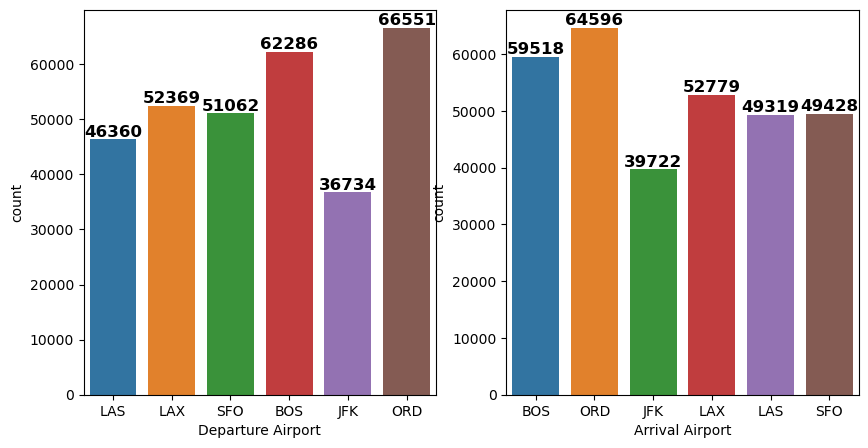

In [34]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
ax = sns.countplot(x= df1['Departure Airport'])

for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=12, label_type='edge', fontweight='bold')

plt.subplot(1,2,2)
ax = sns.countplot(x= df1['Arrival Airport'])

for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=12, label_type='edge', fontweight='bold')

In [35]:
## Creating mapping dictionary

airport_mapping = {
    'LAS': 1,
    'LAX': 2,
    'SFO': 3,
    'BOS': 4,
    'JFK': 5,
    'ORD': 6
}

## updating the Departure Airport columns with the mapping

df1['Departure Airport'] = df1['Departure Airport'].map(airport_mapping)
df1['Arrival Airport'] = df1['Arrival Airport'].map(airport_mapping)

df1

,Flight Lands Next Day,Departure Airport,Arrival Airport,Number Of Stops,Route,Airline,Cabin,Price,DaysbeforeTravel,TravelTime
0,1,1,4,1,ATL,Spirit Airlines,1,83,16,15.250000
1,0,1,4,1,EWR,Spirit Airlines,1,100,16,10.150000
2,1,1,4,1,ATL,Spirit Airlines,1,78,16,15.250000
3,0,1,4,1,IAH,Spirit Airlines,1,100,16,11.116667
4,0,1,4,1,ORD,American Airlines,1,148,16,9.600000
...,...,...,...,...,...,...,...,...,...,...
317255,0,1,4,1,DEN,United Airlines,1,219,17,10.716667
317256,0,1,4,1,PHX,American Airlines,1,218,17,10.700000
317257,1,1,4,1,IAD,United Airlines,1,198,17,10.783333
317258,1,1,4,1,JFK,JetBlue,1,154,17,13.466667


<span style="color:brown; font-weight:bold; font-size:24px;">Top 5 Airlines</span>

In [36]:
top_5_airlines = df1['Airline'].value_counts().head(5).index
df1 = df1[df1['Airline'].isin(top_5_airlines)]
df1

,Flight Lands Next Day,Departure Airport,Arrival Airport,Number Of Stops,Route,Airline,Cabin,Price,DaysbeforeTravel,TravelTime
0,1,1,4,1,ATL,Spirit Airlines,1,83,16,15.250000
1,0,1,4,1,EWR,Spirit Airlines,1,100,16,10.150000
2,1,1,4,1,ATL,Spirit Airlines,1,78,16,15.250000
3,0,1,4,1,IAH,Spirit Airlines,1,100,16,11.116667
4,0,1,4,1,ORD,American Airlines,1,148,16,9.600000
...,...,...,...,...,...,...,...,...,...,...
317254,1,1,4,1,PHL,American Airlines,1,148,17,11.250000
317255,0,1,4,1,DEN,United Airlines,1,219,17,10.716667
317256,0,1,4,1,PHX,American Airlines,1,218,17,10.700000
317257,1,1,4,1,IAD,United Airlines,1,198,17,10.783333


In [37]:
top_5_airlines

Index(['United Airlines', 'Alaska Airlines', 'Delta', 'American Airlines',
       'Spirit Airlines'],
      dtype='object', name='Airline')

In [38]:
#creating the mapping dictionary

airline_mapping = {
    'Alaska Airlines':1,
    'American Airlines':2,
    'Delta' :3,
    'Spirit Airlines':4,
    'United Airlines':5
}

df1['Airline'] = df1['Airline'].map(airline_mapping)
df1

,Flight Lands Next Day,Departure Airport,Arrival Airport,Number Of Stops,Route,Airline,Cabin,Price,DaysbeforeTravel,TravelTime
0,1,1,4,1,ATL,4,1,83,16,15.250000
1,0,1,4,1,EWR,4,1,100,16,10.150000
2,1,1,4,1,ATL,4,1,78,16,15.250000
3,0,1,4,1,IAH,4,1,100,16,11.116667
4,0,1,4,1,ORD,2,1,148,16,9.600000
...,...,...,...,...,...,...,...,...,...,...
317254,1,1,4,1,PHL,2,1,148,17,11.250000
317255,0,1,4,1,DEN,5,1,219,17,10.716667
317256,0,1,4,1,PHX,2,1,218,17,10.700000
317257,1,1,4,1,IAD,5,1,198,17,10.783333


<span style="color:brown; font-weight:bold; font-size:24px;">Route feature</span>

In [39]:
## checking for unique routes
df1['Route'].nunique()

## Top 50 routes
df1['Route'].value_counts().head(50)

## Dropping the Route column
df1 = df1.drop(columns = ['Route'], axis =1)

In [40]:
df1.head()

,Flight Lands Next Day,Departure Airport,Arrival Airport,Number Of Stops,Airline,Cabin,Price,DaysbeforeTravel,TravelTime
0,1,1,4,1,4,1,83,16,15.250000
1,0,1,4,1,4,1,100,16,10.150000
2,1,1,4,1,4,1,78,16,15.250000
3,0,1,4,1,4,1,100,16,11.116667
4,0,1,4,1,2,1,148,16,9.600000


<span style="color:brown; font-weight:bold; font-size:24px;">Distribution of Price wrt Cabin </span>

Text(0, 0.5, 'Price')

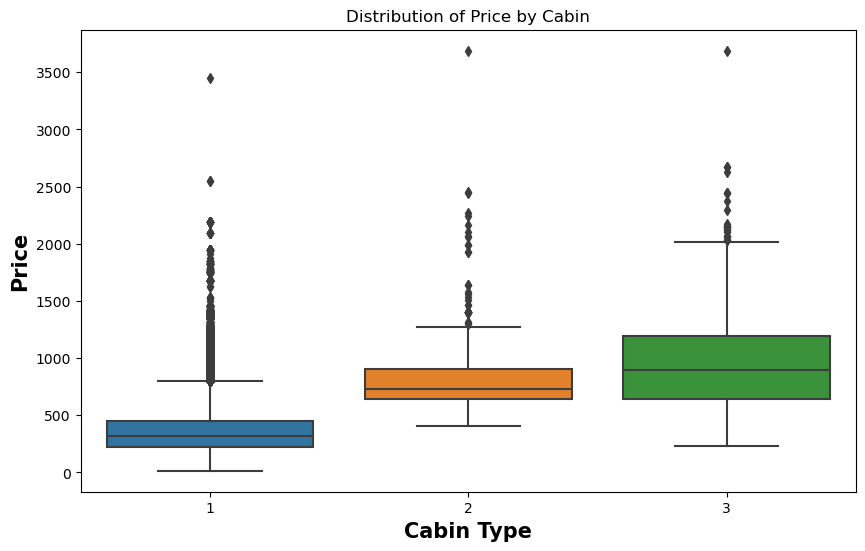

In [41]:
plt.figure(figsize=(10,6))
sns.boxplot(x= df1['Cabin'], y= df1['Price'])

plt.title("Distribution of Price by Cabin")
plt.xlabel("Cabin Type", fontweight = 'bold', fontsize=15)
plt.ylabel("Price", fontweight = 'bold', fontsize=15)

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<span style="color:brown; font-weight:bold; font-size:24px;">Insights:</span>

- ##### **Type 1 Cabin** with **lower prices**, while **Cabin 3** being the **most expensive** Cabin

<span style="color:brown; font-weight:bold; font-size:24px;">Distribution of Price wrt Travel time </span>

Text(0, 0.5, 'Price')

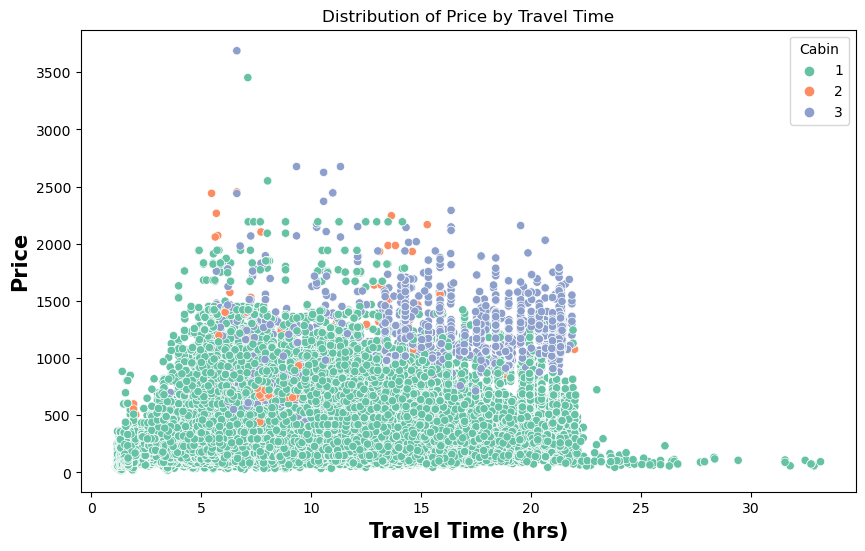

In [42]:
plt.figure(figsize=(10,6))
sns.scatterplot(x= df1['TravelTime'], y= df1['Price'], hue=df1['Cabin'],palette='Set2')

plt.title("Distribution of Price by Travel Time")
plt.xlabel("Travel Time (hrs)", fontweight = 'bold', fontsize=15)
plt.ylabel("Price", fontweight = 'bold', fontsize=15)

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<span style="color:brown; font-weight:bold; font-size:24px;">Insights:</span>

- ##### Most flights of Cabin type 1, cluster around lower prices and shorter travel times. Cabin Type 3 are having higher prices with longer travel times. But irrespective of the travel time, higher cabin types always have higher prices

<span style="color:brown; font-weight:bold; font-size:24px;">Distribution of Price wrt No of Stops </span>

Text(0, 0.5, 'Price')

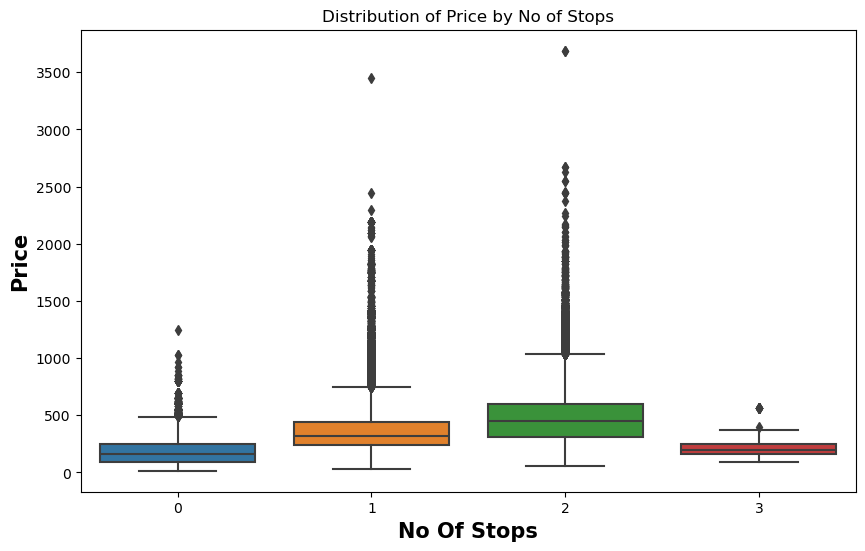

In [43]:
plt.figure(figsize=(10,6))
sns.boxplot(x= df1['Number Of Stops'], y= df1['Price'])

plt.title("Distribution of Price by No of Stops")
plt.xlabel("No Of Stops", fontweight = 'bold', fontsize=15)
plt.ylabel("Price", fontweight = 'bold', fontsize=15)

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<span style="color:brown; font-weight:bold; font-size:24px;">Insights:</span>

- ##### Direct flights (0 stops) prices are the cheapest, Flights with 1 stops whosing the higher price variability, WHile 3-stop flights have low median price than 1 & 2 stops flights but still shows some outliers

<span style="color:brown; font-weight:bold; font-size:24px;">Distribution of Price wrt Days before Travel </span>

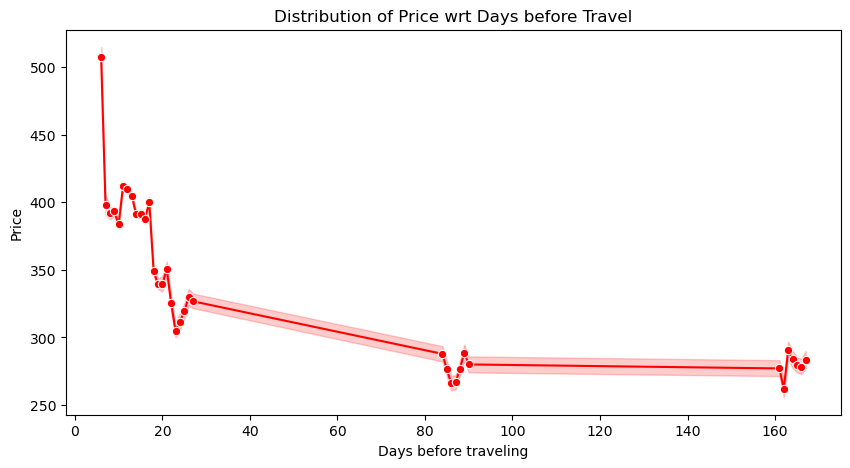

In [44]:
plt.figure(figsize=(10,5))
sns.lineplot(x= df1['DaysbeforeTravel'], y=df1['Price'], marker= 'o', color='red')
plt.title("Distribution of Price wrt Days before Travel")
plt.xlabel('Days before traveling')
plt.ylabel('Price')
plt.show()

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<span style="color:brown; font-weight:bold; font-size:24px;">Insights:</span>

- ##### Generally, As the number of days before travel increase, flight prices decrease. We can observe upto 20days before travel, prices are between 500-300 . Prices stabilize around 80days before travel time

<span style="color:brown; font-weight:bold; font-size:24px;">Distribution of Price wrt Airline</span>

Text(0, 0.5, 'Price')

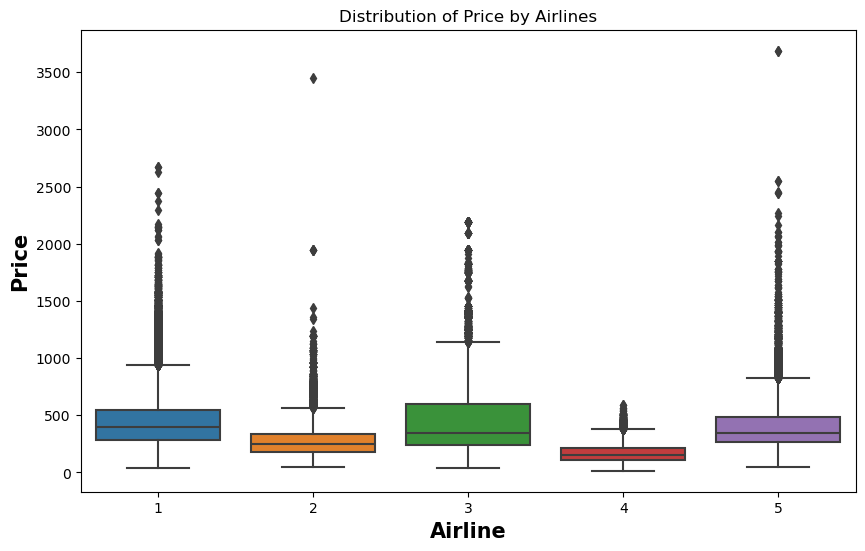

In [45]:
plt.figure(figsize=(10,6))
sns.boxplot(x= df1['Airline'], y= df1['Price'])

plt.title("Distribution of Price by Airlines")
plt.xlabel("Airline", fontweight = 'bold', fontsize=15)
plt.ylabel("Price", fontweight = 'bold', fontsize=15)

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<span style="color:brown; font-weight:bold; font-size:24px;">Insights:</span>

- ##### We can see presence of Outliers for each airline. Airline 4 has the low median price while Airline 1 and 3 have similar price distribution. Airline 2 and 5 has widest price range

In [46]:
df1.head()

,Flight Lands Next Day,Departure Airport,Arrival Airport,Number Of Stops,Airline,Cabin,Price,DaysbeforeTravel,TravelTime
0,1,1,4,1,4,1,83,16,15.250000
1,0,1,4,1,4,1,100,16,10.150000
2,1,1,4,1,4,1,78,16,15.250000
3,0,1,4,1,4,1,100,16,11.116667
4,0,1,4,1,2,1,148,16,9.600000


<span style="color:brown; font-weight:bold; font-size:24px;">Correlation Heat map</span>

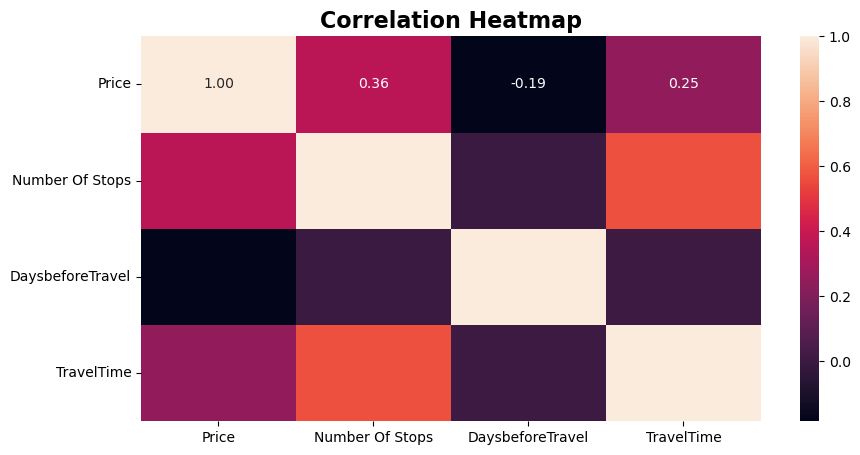

In [47]:
plt.figure(figsize=(10,5))
corr = df1[['Price', 'Number Of Stops', 'DaysbeforeTravel', 'TravelTime']].corr()
sns.heatmap(corr, annot=True,fmt='.2f')
plt.title("Correlation Heatmap", fontweight = 'bold', fontsize=16)
plt.show()


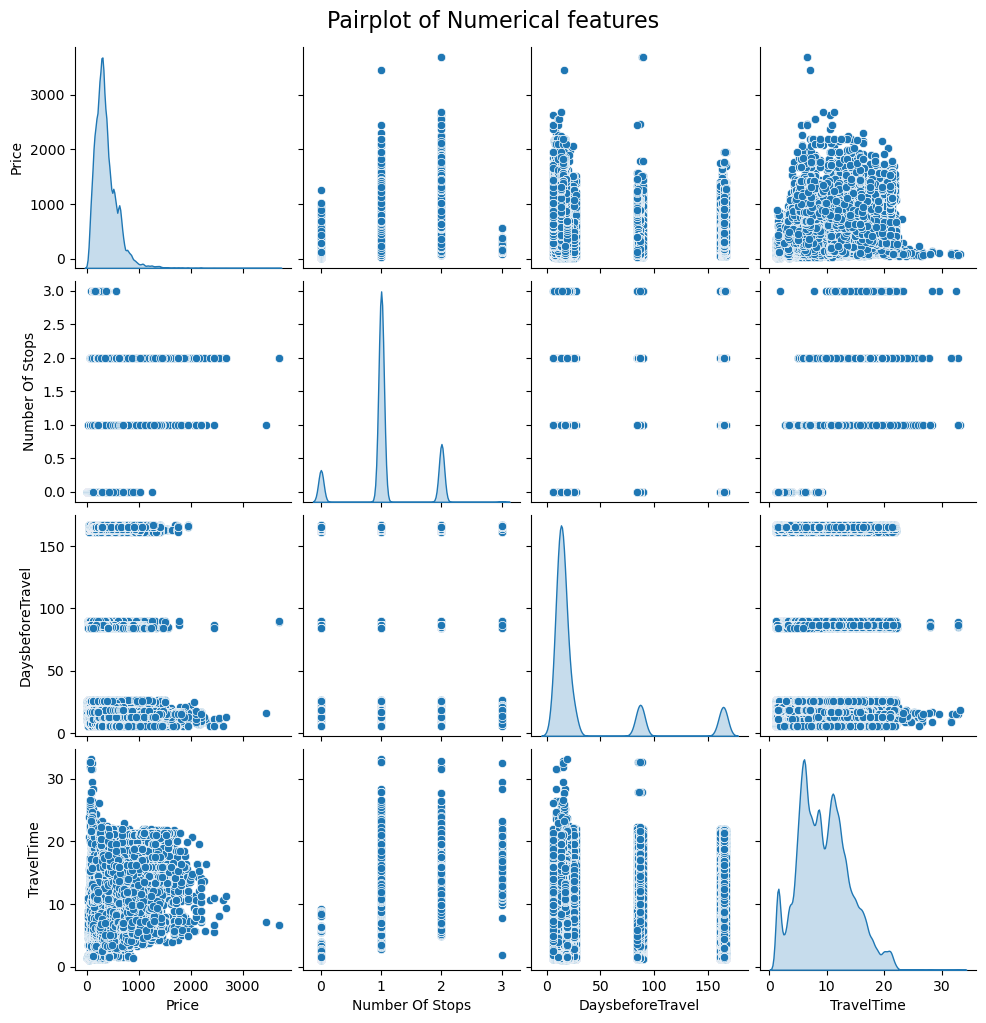

In [48]:
cols = ['Price', 'Number Of Stops', 'DaysbeforeTravel', 'TravelTime']

sns.pairplot(df1[cols], diag_kind = 'kde')
plt.suptitle("Pairplot of Numerical features",y=1.02, fontsize=16)
plt.show()

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<span style="color:brown; font-weight:bold; font-size:24px;">Insights:</span>

- ##### Price has positive correlation with No of stops & Travel time. No of Stops & Travel time are positively correlated. Days before travel shows no relationships with other variables

<span style="color:brown; font-weight:bold; font-size:24px;">Split the Independent & Dependent features</span>

In [49]:
x = df1.drop(columns = ['Price'], axis=1)
y=df1['Price']

<span style="color:brown; font-weight:bold; font-size:24px;">Train & Test Split</span>

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state =42)

In [51]:
print("Shape of x_train is:", x_train.shape)
print("Shape of y_train is:", y_train.shape)
print("Shape of x_test is:", x_test.shape)
print("Shape of y_test is:", y_test.shape)

Shape of x_train is: (234266, 8)
Shape of y_train is: (234266,)
Shape of x_test is: (58567, 8)
Shape of y_test is: (58567,)


<span style="color:brown; font-weight:bold; font-size:24px;">Scaling the data</span>

In [52]:
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [53]:
x_train_scaled

array([[-0.53793309,  1.37541583,  0.2446801 , ..., -0.14387046,
        -0.40123355,  0.03079102],
       [ 1.85896726, -1.51650995,  1.39203698, ..., -0.14387046,
        -0.22452556,  1.2885155 ],
       [-0.53793309,  0.21864552, -1.47635522, ..., -0.14387046,
        -0.35705655, -0.14833943],
       ...,
       [-0.53793309, -1.51650995,  1.39203698, ..., -0.14387046,
        -0.29079106,  0.87689658],
       [-0.53793309,  1.37541583, -1.47635522, ..., -0.14387046,
         1.16704993, -0.29316831],
       [-0.53793309, -0.35973964, -1.47635522, ..., -0.14387046,
        -0.31287956, -1.16595287]])

<a id="1"></a>
# <div style="padding:20px;color:white;margin:0;font-size:25px;font-family:Calibri;text-align:center;display:fill;border-radius:5px;background-color:brown;overflow:hidden"><b> Model Building & Evaluation </b></div>

#### Creating a function to train model using different Regression techniques

In [54]:
r2_value = []
adjusted_r2_value = []
mae_value = []
mse_value = []
rmse_value = []

In [55]:
def model_evaluate(model):
    model.fit(x_train_scaled, y_train)
    y_train_pred = model.predict(x_train_scaled)
    y_test_pred = model.predict(x_test_scaled)

    ## Evaluation
    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_test_pred)
    adjusted_r2 = 1- ((1-r2) * (x_test_scaled.shape[0] -1) / (x_test_scaled.shape[0]-x_test_scaled.shape[1] -1))

    mae_value.append(mae)
    mse_value.append(mse)
    rmse_value.append(rmse)
    r2_value.append(r2)
    adjusted_r2_value.append(adjusted_r2)

    print(f"R2 score of the {model} is -->", r2)
    print(f"Adjusted R2 score of the {model} is -->", adjusted_r2)
    print("-"*50)
    print(f"MAE of the {model} is -->", mae)
    print(f"MSE of the {model} is -->", mse)
    print(f"RMSE of the {model} is -->", rmse)

    ### Scatter plot
    plt.figure(figsize = (15,5))
    plt.subplot(1,2,1)
    plt.scatter(x= y_train, y=y_train_pred, color = 'red', label = 'Train')
    plt.scatter(x=y_test, y=y_test_pred, color = 'blue', label = 'Test')
    plt.xlabel("True Values")
    plt.ylabel("Predicted values")
    plt.legend()
    plt.title("True vs Predicted Values", fontweight = 'black', size = 15)

    ### Residual Plot
    plt.subplot(1,2,2)
    plt.scatter(x = y_train_pred, y = y_train_pred - y_train, color = 'red', label = 'Train')
    plt.scatter(x = y_test_pred, y = y_test_pred - y_test, color = 'blue', label = 'Test')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.legend()
    plt.title("Residual Plot", fontweight = 'black', size = 15)
    plt.show()

<span style="color:Purple; font-weight:bold; font-size:24px;">1. Linear regression</span>

R2 score of the LinearRegression() is --> 0.2837604313480151
Adjusted R2 score of the LinearRegression() is --> 0.2836625810705259
--------------------------------------------------
MAE of the LinearRegression() is --> 133.69336331751447
MSE of the LinearRegression() is --> 33509.52709804941
RMSE of the LinearRegression() is --> 183.05607637565438


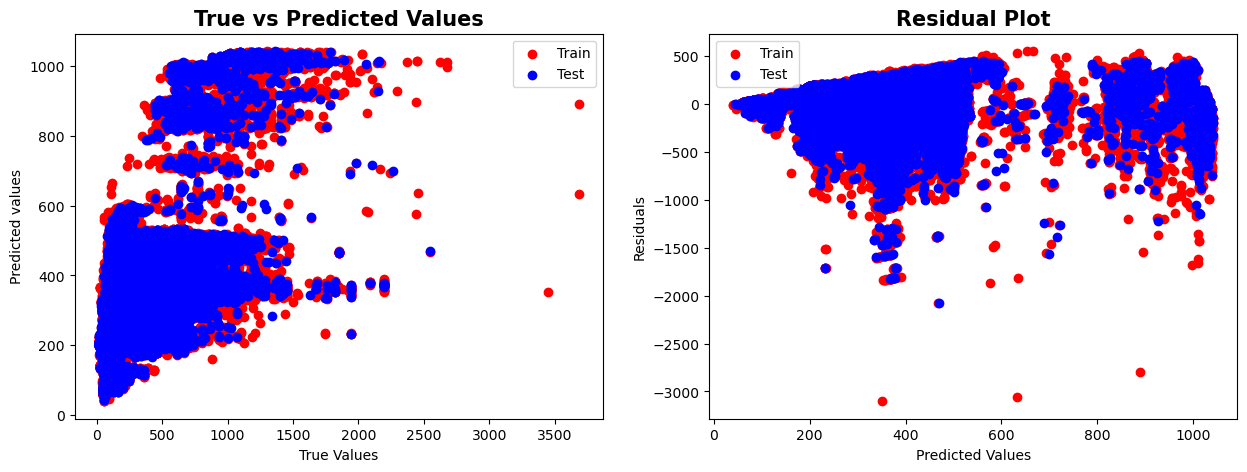

In [56]:
model_evaluate(LinearRegression())

<span style="color:Purple; font-weight:bold; font-size:24px;">2. Ridge Regressor</span>

R2 score of the Ridge() is --> 0.28376043743726653
Adjusted R2 score of the Ridge() is --> 0.2836625871606091
--------------------------------------------------
MAE of the Ridge() is --> 133.69338027152247
MSE of the Ridge() is --> 33509.52681316158
RMSE of the Ridge() is --> 183.05607559751078


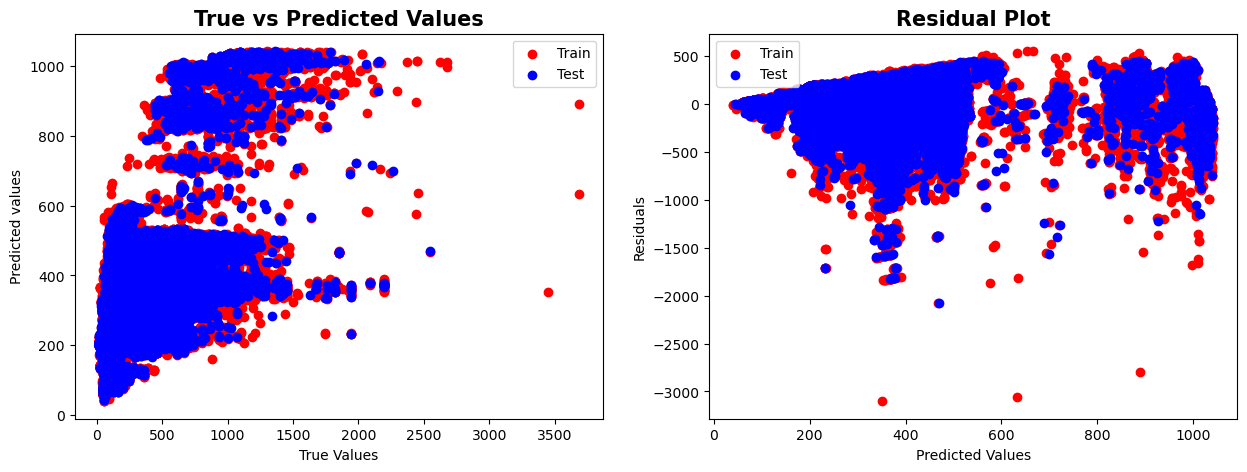

In [57]:
model_evaluate(Ridge(alpha = 1.0))

<span style="color:Purple; font-weight:bold; font-size:24px;">3. Lasso Regressor</span>

R2 score of the Lasso(alpha=0.1) is --> 0.2837471208048751
Adjusted R2 score of the Lasso(alpha=0.1) is --> 0.28364926870894347
--------------------------------------------------
MAE of the Lasso(alpha=0.1) is --> 133.699850322508
MSE of the Lasso(alpha=0.1) is --> 33510.149836621196
RMSE of the Lasso(alpha=0.1) is --> 183.0577773180402


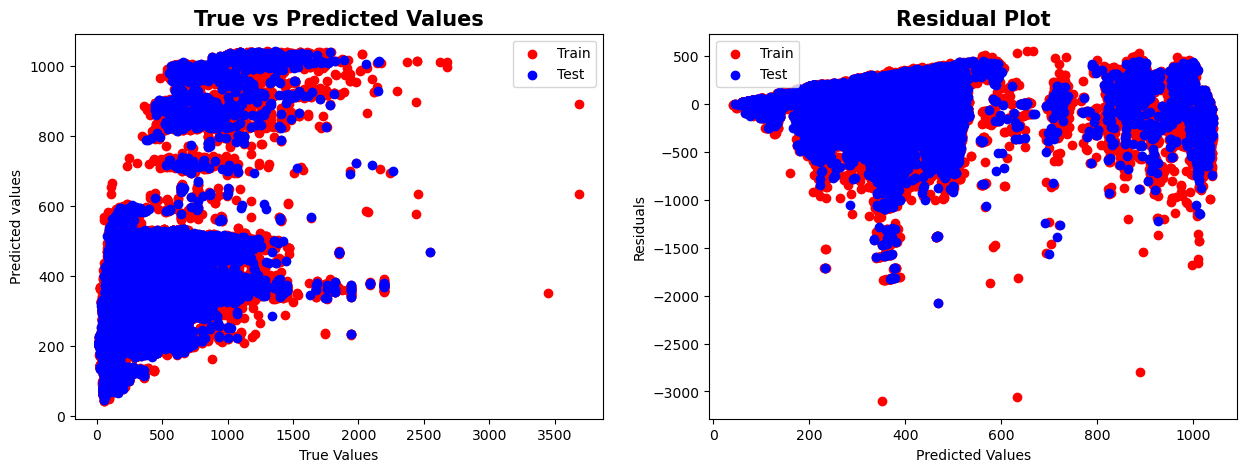

In [58]:
model_evaluate(Lasso(alpha=0.1))

<span style="color:Purple; font-weight:bold; font-size:24px;">4 .Random Forest Regressor</span>

R2 score of the RandomForestRegressor(random_state=42) is --> 0.7468667217233426
Adjusted R2 score of the RandomForestRegressor(random_state=42) is --> 0.7468321394933106
--------------------------------------------------
MAE of the RandomForestRegressor(random_state=42) is --> 65.46357761913632
MSE of the RandomForestRegressor(random_state=42) is --> 11842.931917031876
RMSE of the RandomForestRegressor(random_state=42) is --> 108.8252356626526


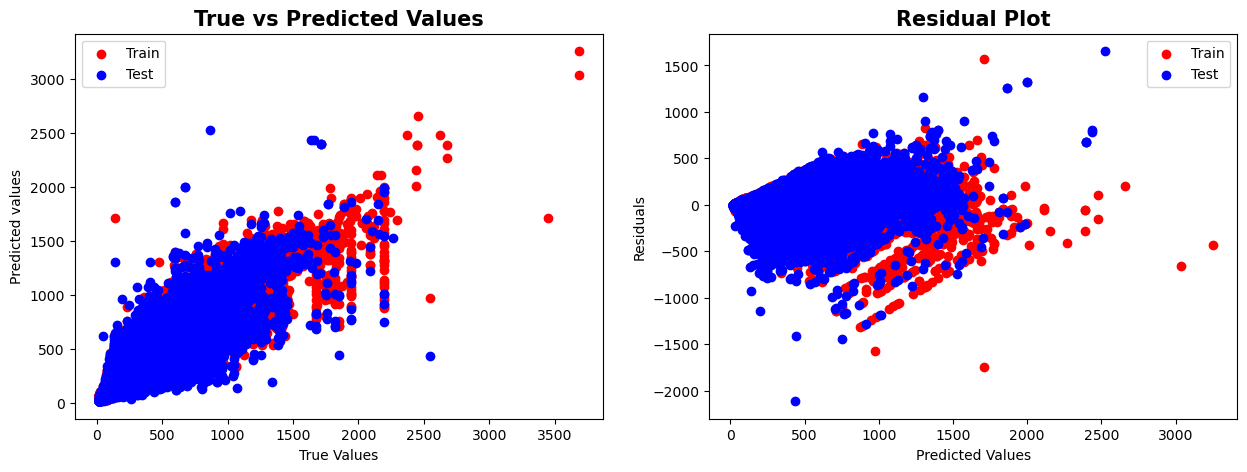

In [59]:
model_evaluate(RandomForestRegressor(n_estimators=100, random_state=42))

<span style="color:Purple; font-weight:bold; font-size:24px;">5. Ada Boost Regressor</span>

R2 score of the AdaBoostRegressor() is --> -0.09272921890655672
Adjusted R2 score of the AdaBoostRegressor() is --> -0.09287850395302777
--------------------------------------------------
MAE of the AdaBoostRegressor() is --> 186.48886451633317
MSE of the AdaBoostRegressor() is --> 51123.73146417362
RMSE of the AdaBoostRegressor() is --> 226.1055759245526


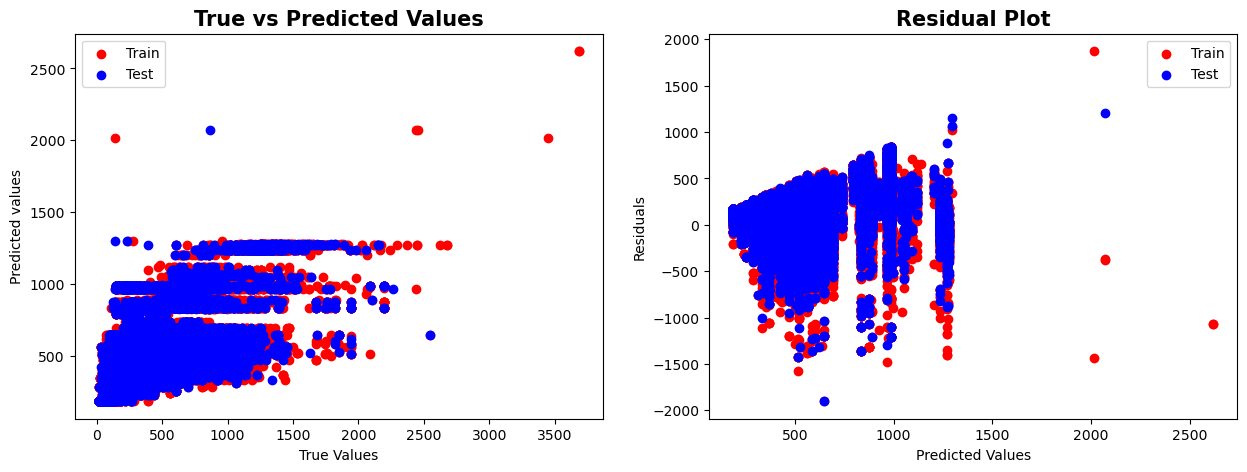

In [60]:
model_evaluate(AdaBoostRegressor())

<span style="color:Purple; font-weight:bold; font-size:24px;">6. Gradient Boost Regressor</span>

R2 score of the GradientBoostingRegressor() is --> 0.6061568812127368
Adjusted R2 score of the GradientBoostingRegressor() is --> 0.6061030756703634
--------------------------------------------------
MAE of the GradientBoostingRegressor() is --> 97.22583185685411
MSE of the GradientBoostingRegressor() is --> 18426.092663688967
RMSE of the GradientBoostingRegressor() is --> 135.74274442374062


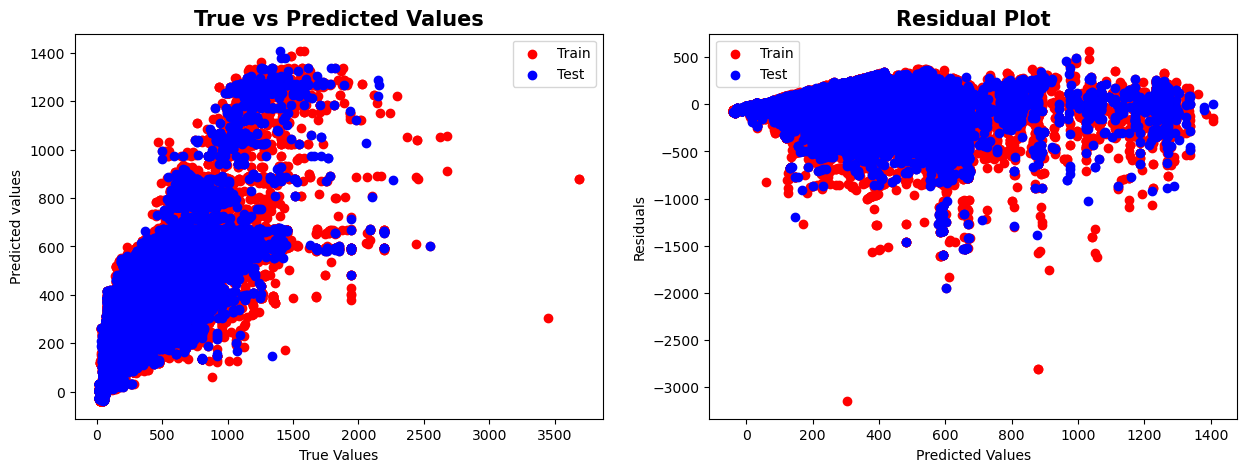

In [61]:
model_evaluate(GradientBoostingRegressor())

<span style="color:Purple; font-weight:bold; font-size:24px;">7.LGBM Regressor</span>

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 324
[LightGBM] [Info] Number of data points in the train set: 234266, number of used features: 8
[LightGBM] [Info] Start training from score 366.752542
R2 score of the LGBMRegressor() is --> 0.7001019998960674
Adjusted R2 score of the LGBMRegressor() is --> 0.7000610288246368
--------------------------------------------------
MAE of the LGBMRegressor() is --> 83.61717491914493
MSE of the LGBMRegressor() is --> 14030.836330429682
RMSE of the LGBMRegressor() is --> 118.45183126667852


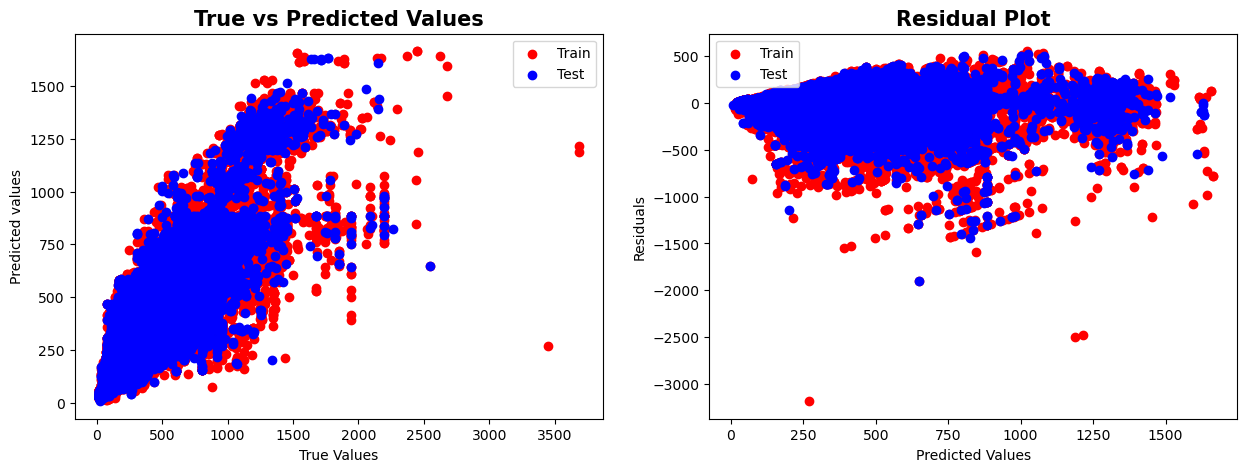

In [62]:
model_evaluate(LGBMRegressor())

<span style="color:Purple; font-weight:bold; font-size:24px;">8.XGB Regressor</span>

R2 score of the XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) is --> 0.7288968833845082
Adjusted R2 score of the XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_ro

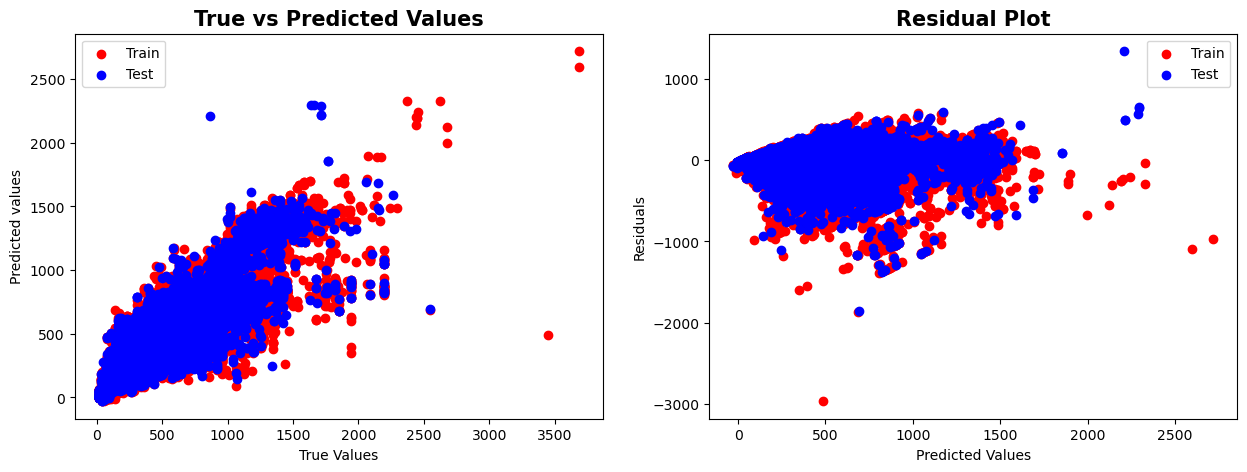

In [63]:
model_evaluate(XGBRegressor())

<span style="color:Purple; font-weight:bold; font-size:24px;">9 .Cat Boost Regressor</span>

R2 score of the <catboost.core.CatBoostRegressor object at 0x32a8a7690> is --> 0.726909302260821
Adjusted R2 score of the <catboost.core.CatBoostRegressor object at 0x32a8a7690> is --> 0.7268719935142465
--------------------------------------------------
MAE of the <catboost.core.CatBoostRegressor object at 0x32a8a7690> is --> 78.44658756273667
MSE of the <catboost.core.CatBoostRegressor object at 0x32a8a7690> is --> 12776.647000024523
RMSE of the <catboost.core.CatBoostRegressor object at 0x32a8a7690> is --> 113.03383121890774


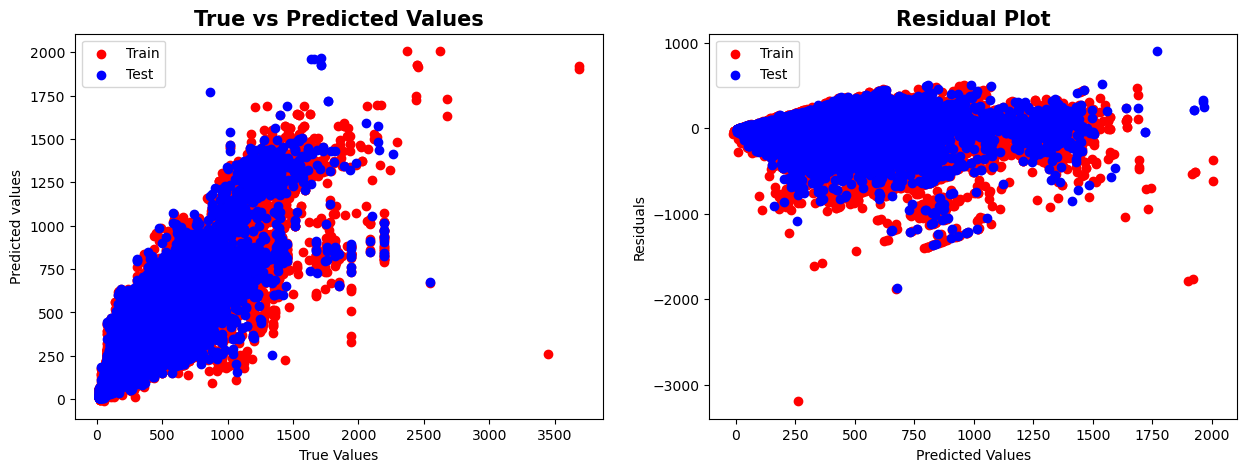

In [64]:
model_evaluate(CatBoostRegressor(verbose=False))

<span style="color:Purple; font-weight:bold; font-size:24px;">Models performance Comparision</span>

In [65]:
models = ['LinearRegression','RidgeRegressor', 'LassoRegressor','RandomForestRegressor', 'AdaBoostRegressor', 'GradientBoostRegressor',
         'LGBMRegressor', 'XGBoostRegressor', 'CatBoostRegressor']


In [66]:
models_eval_df = pd.DataFrame({"Model":models,"R2_Score":r2_value,"Adjusted_R2_Score":adjusted_r2_value,
                       "MAE":mae_value,"MSE":mse_value,"RMSE":rmse_value})



In [67]:
models_eval_df

,Model,R2_Score,Adjusted_R2_Score,MAE,MSE,RMSE
0,LinearRegression,0.283760,0.283663,133.693363,33509.527098,183.056076
1,RidgeRegressor,0.283760,0.283663,133.693380,33509.526813,183.056076
2,LassoRegressor,0.283747,0.283649,133.699850,33510.149837,183.057777
3,RandomForestRegressor,0.746867,0.746832,65.463578,11842.931917,108.825236
4,AdaBoostRegressor,-0.092729,-0.092879,186.488865,51123.731464,226.105576
5,GradientBoostRegressor,0.606157,0.606103,97.225832,18426.092664,135.742744
6,LGBMRegressor,0.700102,0.700061,83.617175,14030.836330,118.451831
7,XGBoostRegressor,0.728897,0.728860,77.960711,12683.657299,112.621744
8,CatBoostRegressor,0.726909,0.726872,78.446588,12776.647000,113.033831


<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font color=brown>Insights:</font></h3>

* Non-linear models significantly outperform Linear models
* The **best performing** model is **Random Forest** followed by **XGBoostRegressor** & **CatBoostRegressor**  with **highest R2 & Adjusted_R2 Scores** and **lowest MAE,MSE,RMSE** values.



In [82]:
model_rf = RandomForestRegressor(n_estimators =100, random_state=42)

# Fit & predict
model_rf.fit(x_train_scaled, y_train)
y_pred = model_rf.predict(x_test_scaled)

# evaluation metrics 
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1- ((1-r2) * (x_test_scaled.shape[0] -1) / (x_test_scaled.shape[0]-x_test_scaled.shape[1] -1))

# results

results = {'MAE' : mae,
           'MASE' : mse,
           'RMSE' : rmse,
           'R2' : r2,
           'Adjusted_r2' :adjusted_r2}

## Feature importance
feature_imp = model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': feature_imp
}).sort_values(by='Importance', ascending=False)

## Display the results

results_df = pd.DataFrame([results])
print("Model Performace Metrics")
print(results_df)

print("\nFeature Importance")
print(importance_df)


Model Performace Metrics
         MAE          MASE        RMSE        R2  Adjusted_r2
0  65.463578  11842.931917  108.825236  0.746867     0.746832

Feature Importance
                 Feature  Importance
7             TravelTime    0.237615
5                  Cabin    0.161276
4                Airline    0.144002
6       DaysbeforeTravel    0.131792
3        Number Of Stops    0.116641
1      Departure Airport    0.105614
2        Arrival Airport    0.093368
0  Flight Lands Next Day    0.009692


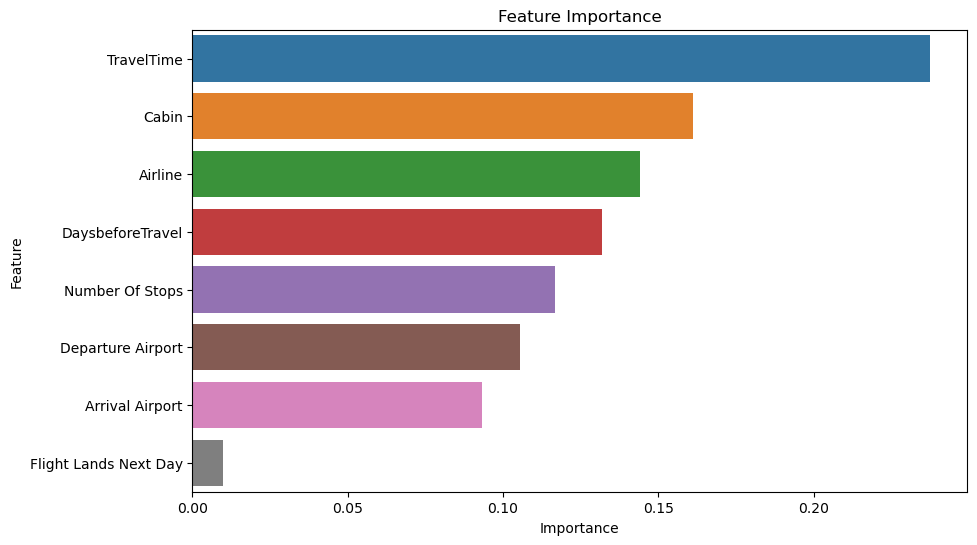

In [76]:
# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font color=brown>Insights:</font></h3>

* Feature importance reveals that **Travel Time** is the most influential feature, followed by **Cabin, Airline, Number of Stops**. Lesse importance is given to features like **Flight Lands Next Day, Arrival and Departure Airport**
* Random Forest performed well with **R2 score of 74%** indicationg strong redictive power

In [77]:
residuals = y_pred - y_test
residuals_pct = (residuals / y_test) * 100


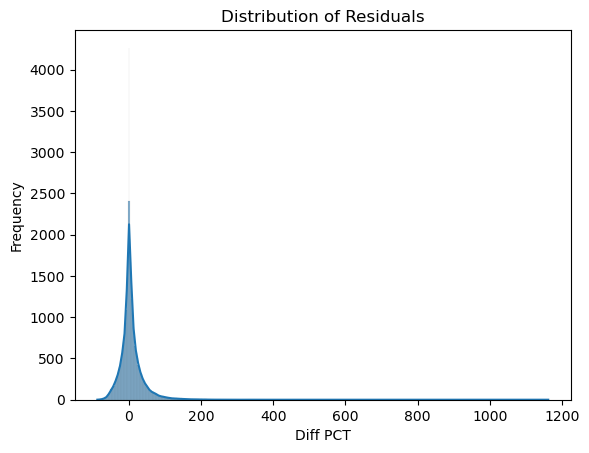

In [78]:

sns.histplot(residuals_pct, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Diff PCT')
plt.ylabel('Frequency')
plt.show()

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font color=brown>Insights:</font></h3>

* The residuals plot shows that most predictions are close to the actual values, with a sharp peak near zero. However, there are some outliers with large errors, indicating the model performs well on average but may struggle with certain predictions

<span style="color:Purple; font-weight:bold; font-size:24px;">Save the Model</span>

In [85]:
import os
from joblib import dump

# Create the directory if it doesn't exist
os.makedirs('fltprcprediction', exist_ok=True)

# Save the model data
model_data = {
    'model': model,
    'scaler': scaler,
}

dump(model_data, 'fltprcprediction/model_data.joblib')

['fltprcprediction/model_data.joblib']